## Scatter Plotting from NetCDF

In this example we show how to programatically download and plot colored depth profilers using OOI NetCDF data. We will use data from the Cabled Array Oregon Slope Base Shallow Profiler Mooring Shallow Profiler CTD. You will learn:

* how to find the data you are looking for
* how to use the machine to machine API to request data
* how to load the NetCDF data into your notebook, once the data request has completed
* how to plot data as a colored scatter plot

For the instrument in this example, you will need the Reference Designator, Stream and Data Delivery Method to make the request to the M2M API. More information about the instrument can be found here:
http://ooi.visualocean.net/instruments/view/RS01SBPS-SF01A-2A-CTDPFA102

![RS01SBPS-SF01A-2A-CTDPFA102](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/RS01SBPS-SF01A-2A-CTDPFA102.png)

In [1]:
import requests
import time

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner), or use the credentials provided below.

In [2]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

Specify your inputs.

In [3]:
subsite = 'RS01SBPS'
node = 'SF01A'
sensor = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'
beginDT = '2016-10-25T01:01:01.000Z'
endDT = '2016-11-01T01:01:01.000Z'

Build the GET request URL and send the request to the M2M API endpoint.

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [5]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180521T205217-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'

Check if the request has completed.

In [6]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 1 s, sys: 68 ms, total: 1.07 s
Wall time: 1min


In [7]:
import re
import xarray as xr
import pandas as pd
import os

Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

In [8]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180521T205217-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20161025T010101.782387-20161101T010100.173894.nc']

Load all files into a single xarray dataset.

In [9]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:                                 (time: 601751)
Coordinates:
    obs                                     (time) int32 dask.array<shape=(601751,), chunksize=(100,)>
  * time                                    (time) datetime64[ns] 2016-10-25T01:01:01.782386688 ...
    seawater_pressure                       (time) float64 dask.array<shape=(601751,), chunksize=(100,)>
    lat                                     (time) float64 dask.array<shape=(601751,), chunksize=(100,)>
    lon                                     (time) float64 dask.array<shape=(601751,), chunksize=(100,)>
Data variables:
    deployment                              (time) int32 dask.array<shape=(601751,), chunksize=(100,)>
    id                                      (time) |S64 dask.array<shape=(601751,), chunksize=(100,)>
    conductivity                            (time) float64 dask.array<shape=(601751,), chunksize=(100,)>
    driver_timestamp                        (time) datetime64[ns] d

Plot the dataset using matplotlib, working under the hood of xarray.

In [13]:
import cmocean
import matplotlib.pyplot as plt

In [11]:
time = ds['time'].values
depth = ds['seawater_pressure'].values
oxygen = ds['corrected_dissolved_oxygen'].values

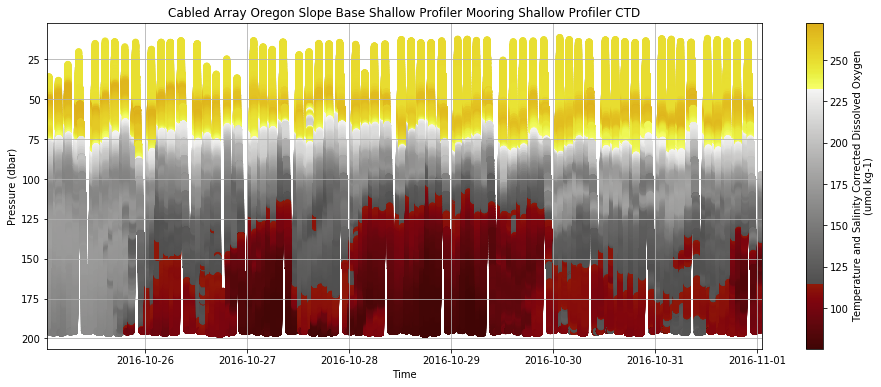

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

ax.invert_yaxis()
ax.grid()
ax.set_xlim(time[0],time[-1])

scatter_plot = plt.scatter(time, depth, c=oxygen, cmap= cmocean.cm.oxy)

cbar = fig.colorbar(scatter_plot, ax=ax)
cbar.update_ticks()
cbar.formatter.set_useOffset(False)

plt.title('Cabled Array Oregon Slope Base Shallow Profiler Mooring Shallow Profiler CTD')
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar.ax.set_ylabel('Temperature and Salinity Corrected Dissolved Oxygen\n(umol kg-1)')

plt.show()

Hypoxic conditions ovv the oregon coast.